# Krypton XY map

## Produce a geometry map

In [42]:
input_path  = f"$IC_DATA/ldst"
output_path = f"$IC_DATA/gdst"
map_path    = f"$IC_DATA/maps"

input_file_names  = ['ldst_6206_0000_19999.h5']
output_file_name  = 'gdst_6206_0000_19999.h5'
map_file_name     = 'gmap_6206_0000_19999.h5'

In [43]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Notebook configuration

In [44]:
import os
import time
import datetime
import collections
import warnings
import pandas as pd
import tables            as tb
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib.dates  as md

import invisible_cities.core.fit_functions as fitf
import invisible_cities.reco.dst_functions as dstf
import invisible_cities.io  .kdst_io       as kdstio

from invisible_cities.core .core_functions import in_range
from invisible_cities.core .stat_functions import poisson_sigma
from invisible_cities.icaro. hst_functions import hist
from invisible_cities.icaro. hst_functions import display_matrix
from invisible_cities.icaro. hst_functions import shift_to_bin_centers
from invisible_cities.icaro. hst_functions import plot_writer

from icaro.core.fit_functions import gauss_seed
from icaro.core.fit_functions import relative_errors
from icaro.core.fit_functions import conditional_labels


In [45]:
import core.kr_histo_functions as krh
import core.kr_core_functions as krc
import core.kr_fit_functions as krf
import core.kr_plt_functions as krp

In [86]:
from core.kr_types import KrEvent, DstEvent, KrRanges, KrNBins, KrBins, KrFit, XYRanges, Ranges
from core.kr_types import XyzRanges, XyzNBins, XyzBins
from core.kr_types import KrMeanAndStd, KrMeanStdMinMax
from core.kr_types import KrLTLimits
from core.kr_types import ExyAvg
from   invisible_cities.evm  .ic_containers  import Measurement

In [47]:
from core.kr_core_functions import kr_event
from core.kr_core_functions import kr_times_ranges_and_bins
from core.kr_core_functions import kr_ranges_and_bins
from core.kr_core_functions import fiducial_volumes

In [48]:
# Plotting style
default_cmap = "viridis"
figure_size  = 8, 6
font_size    = 15

plt.rcParams["figure.figsize"] = figure_size
plt.rcParams[  "font.size"   ] =   font_size

warnings.filterwarnings('ignore', category=tb.NaturalNameWarning)
from icaro.core.fit_functions import conditional_labels

labels = conditional_labels(True)



### Read data

In [49]:
path  = input_path
opath = output_path
mpath = map_path

input_dst_filenames = [os.path.expandvars(f"{path}/{file_name}") for file_name in input_file_names]
output_dst_filename = os.path.expandvars(f"{opath}/{output_file_name}")
map_filename        = os.path.expandvars(f"{mpath}/{map_file_name}")


print(f'input dsts:\n first = {input_dst_filenames[0]}\n last = {input_dst_filenames[-1]}')
print(f"output dst = {output_dst_filename}")
print(f"map file   = {map_filename}")

input dsts:
 first = /Users/jjgomezcadenas/Projects/ICDATA/ldst/ldst_6206_0000_19999.h5
 last = /Users/jjgomezcadenas/Projects/ICDATA/ldst/ldst_6206_0000_19999.h5
output dst = /Users/jjgomezcadenas/Projects/ICDATA/gdst/gdst_6206_0000_19999.h5
map file   = /Users/jjgomezcadenas/Projects/ICDATA/maps/gmap_6206_0000_19999.h5


In [67]:
dst = krc.load_dsts(input_dst_filenames, "DST", "Events")

In [68]:
unique_events = ~dst.event.duplicated()
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of events: {number_of_evts_full}")

Total number of events: 2606375


In [69]:
dst.columns

Index(['index', 'event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w',
       'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

### Ranges and binning

In [70]:
eRanges, eNBins, eBins = kr_ranges_and_bins(Zrange  = ( 100,  550),
                                                     XYrange = (-200,  200),
                                                     Erange  = ( 2e3, 12.5e3),
                                                     S1range = (   2,   25),
                                                     Qrange  = ( 100, 1000),
                                                     Znbins        =   10,
                                                     XYnbins       =   100,
                                                     Enbins        =   50,
                                                     S1nbins       =   10,
                                                     Qnbins        =   25)
pitch = eBins.pXY

### Fiducial volumes

In [71]:
kdst= fiducial_volumes(dst,
                       R_full   = 200,
                       R_fid    = 150,
                       R_core   = 100,
                       R_hcore  =  50)

 nfull : 2544271: eff_full = 0.976172269915112 
 nfid : 1412009: eff_fid = 0.5417520502613784 
 ncore : 619991: eff_core = 0.23787482614742697 
 nhcore : 154786: eff_hcore = 0.059387463431010507 


### Event distribution

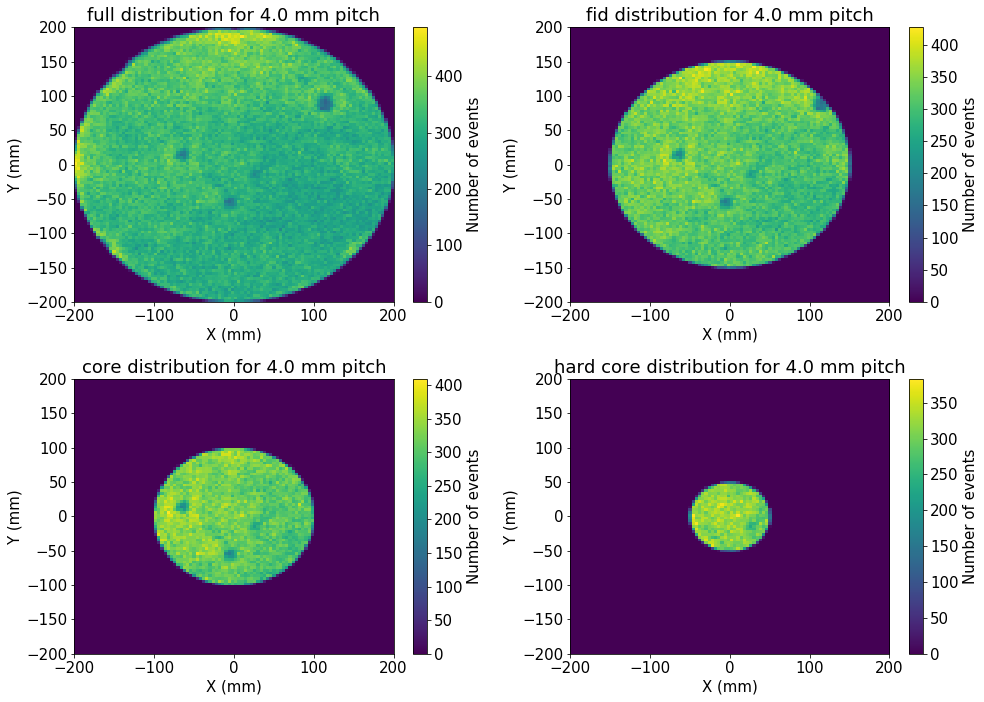

In [72]:
nEvt = krp.plot_xy_density(kdst, eBins)

### Event distribution

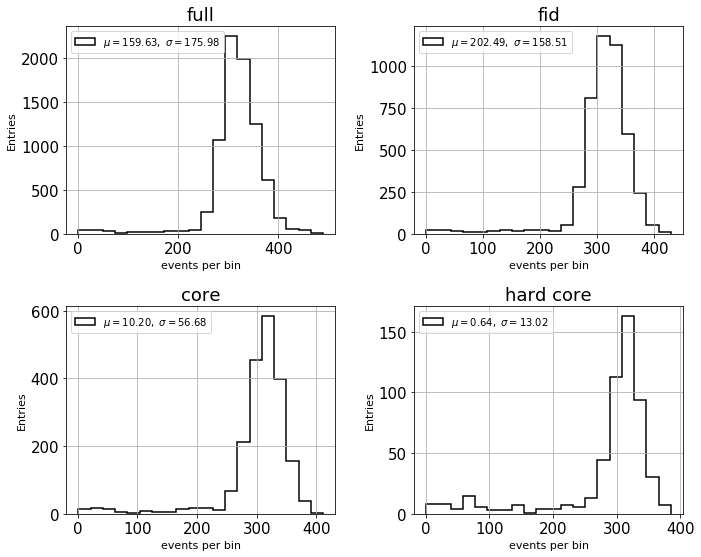

In [73]:
stats = krh.h1n(n=4, nx=2, ny=2, 
                names = ("nevt_full", "fnevt_id", "nevt_core", "nevt_hard core"),
                h1ds = (nEvt.full.flatten(), nEvt.fid.flatten(), nEvt.core.flatten(), nEvt.hcore.flatten()),
                bins = (20, 20, 20, 20),
                ranges = ((1, int(np.max(nEvt.full)) + 2), (1, int(np.max(nEvt.fid)) + 2), 
               (1, int(np.max(nEvt.core)) + 2), (1, int(np.max(nEvt.hcore)) + 2)),
               xlabels = ("events per bin", "events per bin", "events per bin", "events per bin"),
               ylabels = ("Entries", "Entries", "Entries", "Entries"),
               titles = ("full", "fid", "core", "hard core"),
               legends = ("upper left", "upper left", "upper left", "upper left"),
               figsize =(10,8))

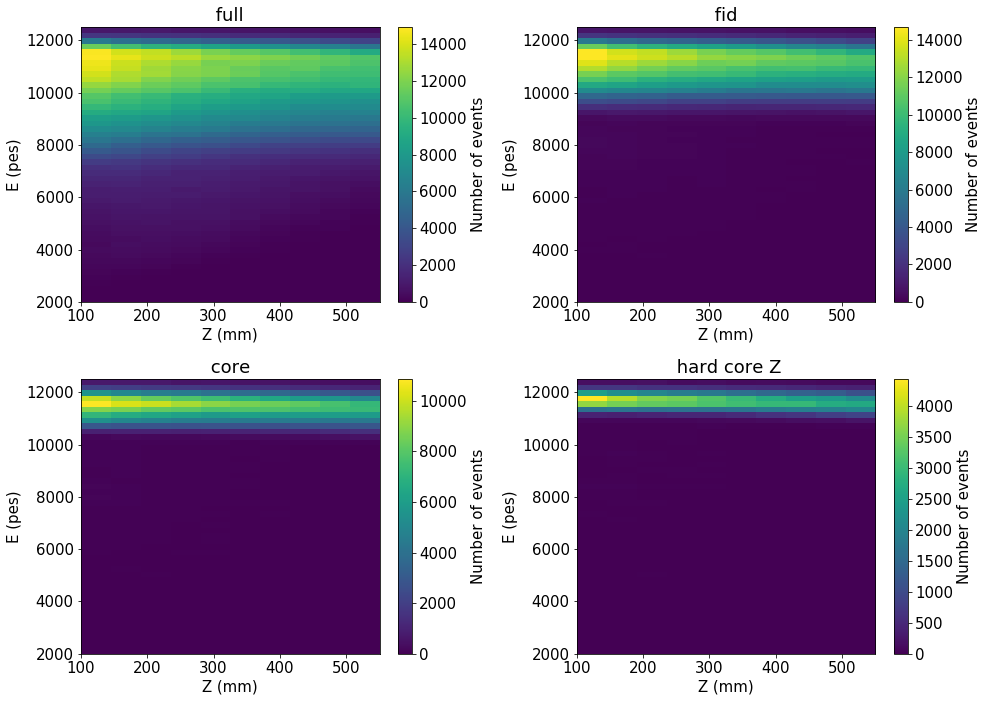

In [74]:
krp.plot_s2_vs_z(kdst, eBins, figsize=(14,10))

### Compute geometry map

In [83]:
def xy_emap(kdst, enbins, eranges):
    *_, eave, eaveu = fitf.profileXY(kdst.X, kdst.Y, kdst.E, 
                                       enbins.XY, enbins.XY, eranges.XY, eranges.XY)
    eaveu_             = relative_errors(eave, eaveu, percentual=True)
    eok                = eave > 1e3
    eXYavg             = ExyAvg(E = eave, Eu = eaveu)
    return eXYavg, eok

In [84]:
eXYavg, eok = xy_emap(kdst.full, eNBins, eRanges)

In [85]:
eXYavg.E.shape

(100, 100)

In [106]:
eok.shape

(100, 100)

In [107]:
np.count_nonzero(eok) / (eok.shape[0] * eok.shape[1])

0.8012

In [90]:
def xy_emap_avg(eXYavg, eok):
    E_mean  = np.mean(eXYavg.E [eok])
    E_std   = np.std (eXYavg.E [eok])
    Eu_mean = np.mean(eXYavg.Eu [eok])
    Eu_std  = np.std (eXYavg.Eu [eok])
    
    E_min   =      E_mean - 2.5 *  E_std
    E_max   =      E_mean + 2.5 *  E_std

    Eu_min  = max(Eu_mean - 2.5 * Eu_std, 1e-3)
    Eu_max  =     Eu_mean + 2.5 * Eu_std
    
    eMapAvg = KrMeanStdMinMax(mu    = E_mean,
                              std   = E_std,
                              mu_u  = Eu_mean,
                              std_u = Eu_std,
                              min   = E_min,
                              max   = E_max,
                              min_u = Eu_min,
                              max_u = Eu_max)
    return eMapAvg

In [92]:
eMapAvg = xy_emap_avg(eXYavg, eok)

In [93]:
eMapAvg

KrMeanStdMinMax(mu=9900.2343828557514, std=1436.8250929227988, mu_u=48.06243554360227, std_u=33.436733676008949, min=6308.1716505487548, max=13492.297115162748, min_u=0.001, max_u=131.65426973362463)

### Fit example

0.10489296913146973


KrFit(par=array([  4.54141808e+05,   1.17429713e+04,   2.45586809e+02]), err=array([  1.02902368e+04,   5.56498134e+00,   4.12173490e+00]), chi2=1.6920100661162212)

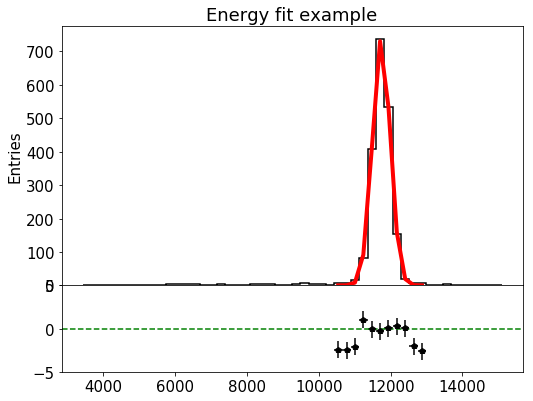

In [96]:
ti = time.time()
kf = krf.energy_in_XYRange(kdst.full, 
                           xr = (-5,  5),
                           yr = (-5,  5),
                           ernb = eNBins)
to = time.time()
print(to - ti)
kf

KrFit(par=array([ 86168.85136772,   9666.692926  ,    192.47469674]), err=array([ 3763.02600576,     8.40713506,     6.75782006]), chi2=1.3970319688869475)

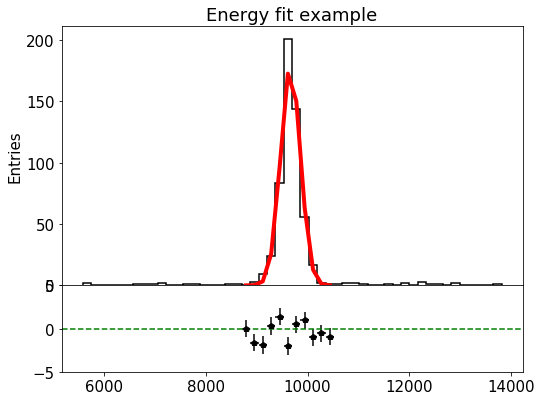

In [95]:
kf = krf.energy_in_XYRange(kdst.full, 
                           xr = (100,  105),
                           yr = (100,  105),
                           ernb = eNBins)
kf

### Energy map display

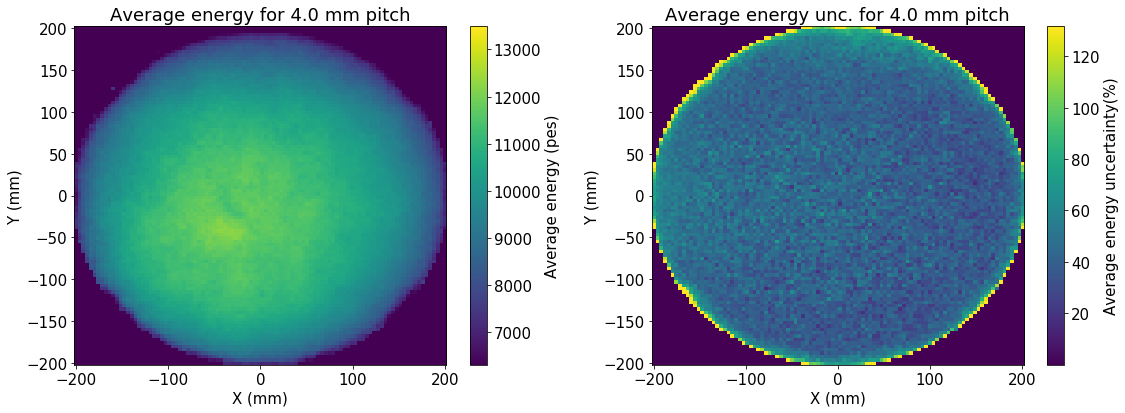

In [117]:
fig = plt.figure(figsize=(16,6))
pitch = eBins.pXY
fig.add_subplot(1, 2, 1)
*_, cb = display_matrix(eBins.cXY, eBins.cXY, eXYavg.E,
                        vmin = eMapAvg.min,
                        vmax = eMapAvg.max,
                        cmap = default_cmap,
                        new_figure = False)
cb.set_label("Average energy (pes)")
labels("X (mm)", "Y (mm)", f"Average energy for {pitch:.1f} mm pitch")
fig.add_subplot(1, 2, 2)
*_, cb = display_matrix(eBins.cXY, eBins.cXY, eXYavg.Eu,
                            vmin = eMapAvg.min_u,
                            vmax = eMapAvg.max_u,
                            cmap = default_cmap,
                            new_figure = False)
cb.set_label("Average energy uncertainty(%)")
labels("X (mm)", "Y (mm)", f"Average energy unc. for {pitch:.1f} mm pitch")

plt.tight_layout()





### Produce HDF5 output

In [119]:
with tb.open_file(map_filename, "w") as output_file:
   
    pitch      = eBins.pXY
    group      =  "XYcorrections"
    table_name = f"GeometryE_{pitch:.1f}mm"
        
    write = kdstio.xy_correction_writer(output_file,
                                            group      = group,
                                            table_name = table_name)
    write(eBins.cXY, eBins.cXY, eXYavg.E, eXYavg.Eu * eXYavg.E / 100, nEvt.full)

    table = getattr(getattr(output_file.root, group), table_name)
    table.attrs.xy_bins  = eBins.XY
    table.attrs.xy_pitch = pitch



### Write DST (merged and fiducial)

In [76]:
dst.columns

Index(['index', 'event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w',
       'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

In [77]:
del dst['index']

In [79]:
dst.to_hdf(output_dst_filename,
              key     = "DST"  , mode         = "w",
              format  = "table", data_columns = True,
              complib = "zlib" , complevel    = 4)



In [80]:
with tb.open_file(output_dst_filename, "r+") as f:
    f.rename_node(f.root.DST.table, "Events")
    f.root.DST.Events.title = "Events"